# Optimizing the Structure of Molecules Using VQE
### What is our program doing?

This program determines the ground state energy of molecules. Specifically, this program determines the ground state energy for BeH2 given various distances between the central beryllium and the two hydrogen atoms attatched to it. We plot those energies to find the position at which the atom is more comfortable, i.e where the energy is lowest.


###Step 1: Imports

We ran into a lot of errors with this considering that there's versions with qiskit.aqua and qiskit.chemistry, neither of which exist anymore. However, when running our program through Azure, we had to use qiskit.aqua and qiskit.chemistry, since it didn't recognize the new version, qiskit_nature. So, this is the final import list we used.

In [ ]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

For reference, this is what the import list with the newest available libraries would look like:

In [ ]:
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper

### Step 2: Define the molecule

We are focusing on BeH2 for this project because it is the largest molecule we could find that would not make the program severely lag.

In this section, we set up the following:
- A Hamiltonian, or an operator representing the total energy of our system. Here, our system is BeH2. Its form is a matrix of numbers.

- Initial parameters that are fed into the ansatz (which we'll get to later), which creates a quantum state for our molecule.

Essentialy, we're determining the approporate qubit operator, H, as well as some other essential information about the operator. To refresh, when the Hamiltonian of our molecule is described by H, the ground state energy of our molecule is at a minimum. 

In [ ]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Be .0 .0 .0; H .0 .0 -" + str(dist) + "; H .0 .0 " \
                         + str(dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, \
                         basis='sto3g')
    molecule = driver.run()

    freeze_list = [0]
    remove_list = [-3, -2]

    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2

    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    
    return qubitOp, num_particles, num_spin_orbitals, shift

### Step 3: Narrowing in on the right answer

Based on how these parameters perform, an optimizer calculates new parameters. This repeats until the desired answer is achieved, or when the determinant of the Hamiltonian is zero. 

Optimizer: We use the SLSQP optimizer because we're not doing noise reduction, though there are lots of other options.

Mapping: We mapped our qubits using the parity mapper, which allows the final Hamiltonian to be reduced in size by 2 qubits.

Initial state: Otherwise known as the ansatz, this what starts the calculations. We used the UCCSD ansatz in our simulation.

Parametrized circuit: The main part of the program respobsible for calculating the values we're looking for. This will feed values back into the optimizer.



In [ ]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

### Step 4: Visualizing the result

We plotted the list of VQE-generated values on top of the exact values determined by an eigenvalue solver that is built into the imports we used. As you can see, there only appears to be one line, showing that the VQE's values are extremely close to the real values!

The dip in the graph, around atomic distance 1.3, represents the interatomic distance at which the molecule is the most stable. Here, we can easily see that BeH2 is most "comfortable" if its hydrogen atoms are 1.3 about angstroms away from the central beryllium.

Our plot: \

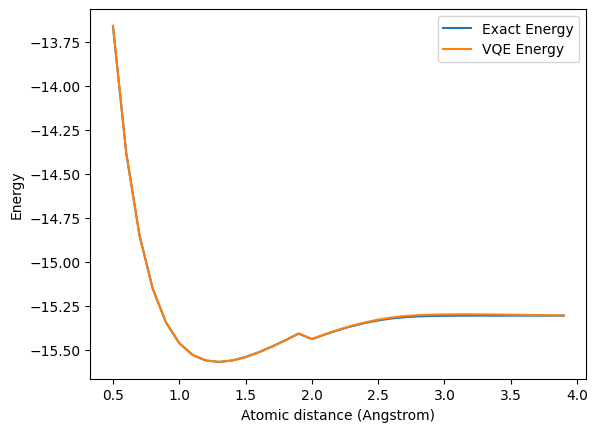

In [ ]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()